## from utils import *

In [2]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    *[f"T{i}" for i in range(1, 35)],
    *[f"TD{i:02d}" for i in range(1, 35)],
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert",
    "Qid",
    "GJ",
]

In [3]:
data = pd.read_pickle("data/decade_price_data_combined_01_09.pkl")

In [4]:
distance_2018 = pd.read_csv(
    "./data/distances/distances_2018_decade_price_data_01_09.csv"
).set_index("Qid1")
distance_2019 = pd.read_csv(
    "./data/distances/distances_2019_decade_price_data_01_09.csv"
).set_index("Qid1")
distance_2020 = pd.read_csv(
    "./data/distances/distances_2020_decade_price_data_01_09.csv"
).set_index("Qid1")
distance_2021 = pd.read_csv(
    "./data/distances/distances_2021_decade_price_data_01_09.csv"
).set_index("Qid1")
distance_2022 = pd.read_csv(
    "./data/distances/distances_2022_decade_price_data_01_09.csv"
).set_index("Qid1")

In [5]:
cleaned_data = data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

# Normalize cols

In [6]:
list_of_t =['TD01', 'TD02', 'TD03', 'TD04',
           'TD05', 'TD06', 'TD07', 'TD08', 'TD09', 'TD10', 'TD11', 'TD12', 'TD13',
           'TD14', 'TD15', 'TD16', 'TD17', 'TD18', 'TD19', 'TD20', 'TD21', 'TD22',
           'TD23', 'TD24', 'TD25', 'TD26', 'TD27', 'TD28', 'TD29', 'TD30', 'TD31',
           'TD32', 'TD33', 'TD34']

for i in list_of_t:
    cleaned_data[i] = (
        cleaned_data[i] - cleaned_data[i].mean()
    ) / cleaned_data[i].std()

cleaned_data.Preis = (
    cleaned_data.Preis - cleaned_data.Preis.mean()
) / cleaned_data.Preis.std()
cleaned_data.Laenge = (
    cleaned_data.Laenge - cleaned_data.Laenge.mean()
) / cleaned_data.Laenge.std()
cleaned_data.Breite = (
    cleaned_data.Breite - cleaned_data.Breite.mean()
) / cleaned_data.Breite.std()
cleaned_data.PPSVACWert = (
    cleaned_data.PPSVACWert - cleaned_data.PPSVACWert.mean()
) / cleaned_data.PPSVACWert.std()

In [7]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

In [8]:
data_2023.loc[:, "T1":"T22"] = data_2023.loc[:, "T1":"T22"].replace(-1, 0)

In [42]:
all_valid_qids = cleaned_data[cleaned_data.Eigenfläche == 1].Qid.unique()

In [43]:
qid_train, qid_val = train_test_split(all_valid_qids, test_size=0.05, random_state=666)

# Data Loading

In [45]:
def DataPreprocessor(qids):
    
    MAX_NEIGH = 10
    
    columns_to_drop = [
        "PPSVACWert",
        *[f"T{i}" for i in range(1, 35)],
        *[f"TD{i:02d}" for i in range(1, 35)],
    ]

    global data_2018, data_2019, data_2020, data_2021, data_2022, data_2023
    global distance_2018, distance_2019, distance_2020, distance_2021, distance_2022
    X, x, y = [], [], []

    all_year_data = [data_2018, data_2019, data_2020, data_2021, data_2022]
    all_year_distances = [
        distance_2018,
        distance_2019,
        distance_2020,
        distance_2021,
        distance_2022,
    ]

    for idx, qid in enumerate(tqdm(qids)):
        
        if (data_2023.index == qid).sum():


            neighbours_features = []

            for year_data, year_distances in zip(all_year_data, all_year_distances):
                current_distances = year_distances[year_distances.index == qid]

                if current_distances.shape[0] != 0:
                    current_year_neighbours = current_distances[
                        current_distances.Qid2 != qid
                    ]
                    current_year_neighbours_data = torch.from_numpy(
                        year_data.loc[current_year_neighbours.Qid2].values
                    )
                    current_year_neighbours_data_padded = pad(
                        current_year_neighbours_data,
                        (0, 0, 0, MAX_NEIGH - current_year_neighbours_data.shape[0]),
                        "constant",
                        0,
                    )

                    current_year_self_data = torch.from_numpy(year_data.loc[qid].values)

                    if (current_year_self_data.ndim == 2) and (
                        current_year_self_data.shape[0] > 1
                    ):
                        current_year_self_data = current_year_self_data[0]

                    current_year_data_point = torch.cat(
                        [current_year_self_data[None], current_year_neighbours_data_padded],
                        dim=0,
                    )

                else:
                    # Fill with dummy zeros
                    current_year_data_point = torch.zeros(11, 78)

                neighbours_features.append(current_year_data_point)


            self_data_2023 = torch.from_numpy(
                data_2023.loc[qid].drop(labels=columns_to_drop).values
            )

            neighbours_features = torch.stack(neighbours_features, dim=0)
            label = torch.tensor(data_2023.loc[qid, "T1":"T22"].mean())

            X.append(neighbours_features)
            x.append(self_data_2023)
            y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)

    return X, x, y

In [12]:
X_train, x_train, y_train = DataPreprocessor(qid_train)

100%|████████████████████████████████████| 63586/63586 [04:06<00:00, 257.64it/s]


In [13]:
torch.save(X_train, "./data/X_train_lstm_decade_price_01_09.pt")
torch.save(x_train, "./data/x_train_lstm_decade_price_01_09.pt")
torch.save(y_train, "./data/y_train_lstm_decade_price_01_09.pt")

In [48]:
X_val, x_val, y_val = DataPreprocessor(qid_val)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.00it/s]


In [15]:
torch.save(X_val, "./data/X_val_lstm_decade_price_01_09.pt")
torch.save(x_val, "./data/x_val_lstm_decade_price_01_09.pt")
torch.save(y_val, "./data/y_val_lstm_decade_price_01_09.pt")

In [118]:
test_qids = [9333.,   9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
             9404.,   9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
             9642.,   9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
             9858.,   9859.,   9932.,   9933., 785704., 931305., 931326.,
             9855.,   9948.,  20457.,  20472.,  20594.,  20595.,  20643.,
             20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
             26396., 327508., 327509., 344212., 814900., 840435., 842866.,
             887322., 931310., 931324.,   9860.,   9672.,   9673.,   9674.]

test_qids.sort()

In [119]:
# # loading test data
X_test, x_test, y_test = DataPreprocessor(test_qids)

torch.save(X_test, "./data/X_test_lstm_decade_price_04_09.pt")
torch.save(x_test, "./data/x_test_lstm_decade_price_04_09.pt")
torch.save(y_test, "./data/y_test_lstm_decade_price_04_09.pt")

100%|██████████████████████████████████████████| 56/56 [00:00<00:00, 191.36it/s]


# Models

In [11]:
from utils import *

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)
        
        return out

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_X, path_x, path_y, p=0.1, smooth_labels=False):
        
        self.data_X = torch.load(path_X)
        self.data_X = self.data_X.permute(0, 1, 3, 2)
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)

        self.p = p

    def __getitem__(self, index):
        if torch.rand(1) < self.p:
            return self.__transform(
                self.data_X[index].clone(),
                self.data_x[index].clone(),
                self.data_y[index].clone(),
            )
        else:
            return (
                self.data_X[index],
                self.data_x[index],
                self.data_y[index]
            )

    def __len__(self):
        return len(self.data_X)

    def __transform(self, item_X, item_x, item_y, k=2):
        max_price = max(item_X[:, -6, 0])
        item_x[-5] = k * max_price
        item_y = item_y * 0

        return item_X, item_x, item_y

# Defining hyperparametrs

In [20]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

In [21]:
model = LSTMModel(78, 512, 5, 1).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
train_dataset = CustomDataset(
    "./data/X_train_lstm_decade_price_01_09.pt",
    "./data/x_train_lstm_decade_price_01_09.pt",
    "./data/y_train_lstm_decade_price_01_09.pt",
)

val_dataset = CustomDataset(
    "./data/X_val_lstm_decade_price_01_09.pt",
    "./data/x_val_lstm_decade_price_01_09.pt",
    "./data/y_val_lstm_decade_price_01_09.pt",
)

In [23]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

In [24]:
num_epochs = 200
history = []
val_min_loss = None
model_name = input("Input proper model name:\t")

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()

    for batch in tqdm(train_dataloader, position=0, leave=True):
        
        # Every data instance is an input + label pair
        X_train1 = batch[0].to(torch.float32).to(DEVICE)
        x_train1 = batch[1].to(torch.float32).to(DEVICE)
        y_train1 = batch[2].to(torch.float32).to(DEVICE)
        outputs = model(X_train1, x_train1)
        loss = criterion(outputs, y_train1.view(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()

    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, position=0, leave=True):
            
            # Every data instance is an input + label pair
            X_val1 = batch[0].to(torch.float32).to(DEVICE)
            x_val1 = batch[1].to(torch.float32).to(DEVICE)
            y_val1 = batch[2].to(torch.float32).to(DEVICE)
            outputs = model(X_val1, x_val1)
            loss = criterion(outputs, y_val1.view(-1, 1))
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss / len(train_dataloader)
    mean_val_loss = val_running_loss / len(val_dataloader)


    if val_min_loss is None:
        val_min_loss = mean_val_loss
    elif mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        torch.save(model.state_dict(), f"./models/{model_name}.pth")

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )

Input proper model name:	lstm_training_04_09_2023


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 231.79it/s]


Epoch [1/200]
Train Loss: 0.0579
Val Loss: 0.0435


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 232.00it/s]


Epoch [2/200]
Train Loss: 0.041
Val Loss: 0.0386


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 230.68it/s]


Epoch [3/200]
Train Loss: 0.0382
Val Loss: 0.0369


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 294.14it/s]


Epoch [4/200]
Train Loss: 0.0366
Val Loss: 0.0382


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 245.83it/s]


Epoch [5/200]
Train Loss: 0.036
Val Loss: 0.0385


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.49it/s]


Epoch [6/200]
Train Loss: 0.0351
Val Loss: 0.0355


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 231.27it/s]


Epoch [7/200]
Train Loss: 0.0343
Val Loss: 0.0352


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 269.51it/s]


Epoch [8/200]
Train Loss: 0.0332
Val Loss: 0.0336


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 263.23it/s]


Epoch [9/200]
Train Loss: 0.0323
Val Loss: 0.0328


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 280.84it/s]


Epoch [10/200]
Train Loss: 0.0317
Val Loss: 0.0314


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 229.73it/s]


Epoch [11/200]
Train Loss: 0.0303
Val Loss: 0.0318


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 231.22it/s]


Epoch [12/200]
Train Loss: 0.0295
Val Loss: 0.0285


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 252.42it/s]


Epoch [13/200]
Train Loss: 0.0278
Val Loss: 0.0275


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 280.62it/s]


Epoch [14/200]
Train Loss: 0.0254
Val Loss: 0.0225


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 278.17it/s]


Epoch [15/200]
Train Loss: 0.023
Val Loss: 0.0232


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 280.60it/s]


Epoch [16/200]
Train Loss: 0.0212
Val Loss: 0.0197


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 318.51it/s]


Epoch [17/200]
Train Loss: 0.0202
Val Loss: 0.0202


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.32it/s]


Epoch [18/200]
Train Loss: 0.0193
Val Loss: 0.0211


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.55it/s]


Epoch [19/200]
Train Loss: 0.0183
Val Loss: 0.019


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 345.48it/s]


Epoch [20/200]
Train Loss: 0.0177
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 307.11it/s]


Epoch [21/200]
Train Loss: 0.0173
Val Loss: 0.019


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.22it/s]


Epoch [22/200]
Train Loss: 0.0169
Val Loss: 0.0167


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.74it/s]


Epoch [23/200]
Train Loss: 0.0165
Val Loss: 0.016


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.61it/s]


Epoch [24/200]
Train Loss: 0.0163
Val Loss: 0.016


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.70it/s]


Epoch [25/200]
Train Loss: 0.0163
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.83it/s]


Epoch [26/200]
Train Loss: 0.0159
Val Loss: 0.0162


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 359.18it/s]


Epoch [27/200]
Train Loss: 0.0155
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.28it/s]


Epoch [28/200]
Train Loss: 0.0154
Val Loss: 0.0163


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.78it/s]


Epoch [29/200]
Train Loss: 0.016
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.92it/s]


Epoch [30/200]
Train Loss: 0.0155
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.52it/s]


Epoch [31/200]
Train Loss: 0.015
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.67it/s]


Epoch [32/200]
Train Loss: 0.0148
Val Loss: 0.0152


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.20it/s]


Epoch [33/200]
Train Loss: 0.0147
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 364.26it/s]


Epoch [34/200]
Train Loss: 0.0145
Val Loss: 0.0156


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.42it/s]


Epoch [35/200]
Train Loss: 0.0145
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.88it/s]


Epoch [36/200]
Train Loss: 0.0143
Val Loss: 0.017


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.65it/s]


Epoch [37/200]
Train Loss: 0.0143
Val Loss: 0.0164


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 350.75it/s]


Epoch [38/200]
Train Loss: 0.014
Val Loss: 0.0158


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.38it/s]


Epoch [39/200]
Train Loss: 0.014
Val Loss: 0.0185


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.10it/s]


Epoch [40/200]
Train Loss: 0.0138
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.10it/s]


Epoch [41/200]
Train Loss: 0.0137
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.95it/s]


Epoch [42/200]
Train Loss: 0.0136
Val Loss: 0.0153


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.16it/s]


Epoch [43/200]
Train Loss: 0.0137
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 290.51it/s]


Epoch [44/200]
Train Loss: 0.0137
Val Loss: 0.0159


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.02it/s]


Epoch [45/200]
Train Loss: 0.0135
Val Loss: 0.0145


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.32it/s]


Epoch [46/200]
Train Loss: 0.013
Val Loss: 0.0154


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 367.78it/s]


Epoch [47/200]
Train Loss: 0.0131
Val Loss: 0.0158


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 290.34it/s]


Epoch [48/200]
Train Loss: 0.0128
Val Loss: 0.0154


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 291.47it/s]


Epoch [49/200]
Train Loss: 0.0127
Val Loss: 0.016


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.06it/s]


Epoch [50/200]
Train Loss: 0.0128
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.71it/s]


Epoch [51/200]
Train Loss: 0.0125
Val Loss: 0.0152


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.70it/s]


Epoch [52/200]
Train Loss: 0.0123
Val Loss: 0.0155


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.27it/s]


Epoch [53/200]
Train Loss: 0.0123
Val Loss: 0.0156


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.77it/s]


Epoch [54/200]
Train Loss: 0.0121
Val Loss: 0.0151


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.93it/s]


Epoch [55/200]
Train Loss: 0.0125
Val Loss: 0.017


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.49it/s]


Epoch [56/200]
Train Loss: 0.0118
Val Loss: 0.0159


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 291.15it/s]


Epoch [57/200]
Train Loss: 0.0117
Val Loss: 0.0152


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 290.96it/s]


Epoch [58/200]
Train Loss: 0.0115
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 291.76it/s]


Epoch [59/200]
Train Loss: 0.0114
Val Loss: 0.0154


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.69it/s]


Epoch [60/200]
Train Loss: 0.0115
Val Loss: 0.0158


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.68it/s]


Epoch [61/200]
Train Loss: 0.0112
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 291.43it/s]


Epoch [62/200]
Train Loss: 0.011
Val Loss: 0.0158


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 365.00it/s]


Epoch [63/200]
Train Loss: 0.0109
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 291.37it/s]


Epoch [64/200]
Train Loss: 0.0107
Val Loss: 0.016


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.30it/s]


Epoch [65/200]
Train Loss: 0.0107
Val Loss: 0.0167


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.47it/s]


Epoch [66/200]
Train Loss: 0.0105
Val Loss: 0.0153


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 326.88it/s]


Epoch [67/200]
Train Loss: 0.0104
Val Loss: 0.0156


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.87it/s]


Epoch [68/200]
Train Loss: 0.0101
Val Loss: 0.0163


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.45it/s]


Epoch [69/200]
Train Loss: 0.0101
Val Loss: 0.0157


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 363.94it/s]


Epoch [70/200]
Train Loss: 0.0097
Val Loss: 0.0174


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.18it/s]


Epoch [71/200]
Train Loss: 0.0097
Val Loss: 0.0156


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.65it/s]


Epoch [72/200]
Train Loss: 0.0096
Val Loss: 0.0149


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 369.55it/s]


Epoch [73/200]
Train Loss: 0.0094
Val Loss: 0.0163


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 365.74it/s]


Epoch [74/200]
Train Loss: 0.0093
Val Loss: 0.0169


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 278.92it/s]


Epoch [75/200]
Train Loss: 0.0091
Val Loss: 0.0155


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.80it/s]


Epoch [76/200]
Train Loss: 0.0089
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.69it/s]


Epoch [77/200]
Train Loss: 0.009
Val Loss: 0.0171


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 346.67it/s]


Epoch [78/200]
Train Loss: 0.0086
Val Loss: 0.0166


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.83it/s]


Epoch [79/200]
Train Loss: 0.0083
Val Loss: 0.0169


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 288.12it/s]


Epoch [80/200]
Train Loss: 0.0084
Val Loss: 0.0161


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 288.22it/s]


Epoch [81/200]
Train Loss: 0.0081
Val Loss: 0.0166


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.33it/s]


Epoch [82/200]
Train Loss: 0.0081
Val Loss: 0.0168


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.58it/s]


Epoch [83/200]
Train Loss: 0.0078
Val Loss: 0.0166


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.37it/s]


Epoch [84/200]
Train Loss: 0.0078
Val Loss: 0.0174


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.14it/s]


Epoch [85/200]
Train Loss: 0.0078
Val Loss: 0.0169


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.32it/s]


Epoch [86/200]
Train Loss: 0.0075
Val Loss: 0.0176


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.61it/s]


Epoch [87/200]
Train Loss: 0.0073
Val Loss: 0.0177


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.54it/s]


Epoch [88/200]
Train Loss: 0.0074
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.07it/s]


Epoch [89/200]
Train Loss: 0.0071
Val Loss: 0.0185


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.63it/s]


Epoch [90/200]
Train Loss: 0.007
Val Loss: 0.0161


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 280.91it/s]


Epoch [91/200]
Train Loss: 0.0066
Val Loss: 0.0168


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.48it/s]


Epoch [92/200]
Train Loss: 0.0066
Val Loss: 0.017


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.68it/s]


Epoch [93/200]
Train Loss: 0.0064
Val Loss: 0.0195


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.82it/s]


Epoch [94/200]
Train Loss: 0.0064
Val Loss: 0.0164


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.76it/s]


Epoch [95/200]
Train Loss: 0.0063
Val Loss: 0.0177


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 279.48it/s]


Epoch [96/200]
Train Loss: 0.0062
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.66it/s]


Epoch [97/200]
Train Loss: 0.0058
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.51it/s]


Epoch [98/200]
Train Loss: 0.0059
Val Loss: 0.0195


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.60it/s]


Epoch [99/200]
Train Loss: 0.0055
Val Loss: 0.0165


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.01it/s]


Epoch [100/200]
Train Loss: 0.0055
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.59it/s]


Epoch [101/200]
Train Loss: 0.0054
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 288.71it/s]


Epoch [102/200]
Train Loss: 0.0052
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.02it/s]


Epoch [103/200]
Train Loss: 0.005
Val Loss: 0.0168


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 344.79it/s]


Epoch [104/200]
Train Loss: 0.0051
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.49it/s]


Epoch [105/200]
Train Loss: 0.0052
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.81it/s]


Epoch [106/200]
Train Loss: 0.0048
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 366.72it/s]


Epoch [107/200]
Train Loss: 0.0047
Val Loss: 0.0176


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 359.45it/s]


Epoch [108/200]
Train Loss: 0.0046
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.80it/s]


Epoch [109/200]
Train Loss: 0.0048
Val Loss: 0.0193


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.74it/s]


Epoch [110/200]
Train Loss: 0.0044
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.52it/s]


Epoch [111/200]
Train Loss: 0.0045
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 293.08it/s]


Epoch [112/200]
Train Loss: 0.0041
Val Loss: 0.0176


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.44it/s]


Epoch [113/200]
Train Loss: 0.004
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.31it/s]


Epoch [114/200]
Train Loss: 0.004
Val Loss: 0.0192


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.10it/s]


Epoch [115/200]
Train Loss: 0.004
Val Loss: 0.0174


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.11it/s]


Epoch [116/200]
Train Loss: 0.0039
Val Loss: 0.0189


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.51it/s]


Epoch [117/200]
Train Loss: 0.0038
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.09it/s]


Epoch [118/200]
Train Loss: 0.0039
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 352.84it/s]


Epoch [119/200]
Train Loss: 0.0036
Val Loss: 0.0192


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.63it/s]


Epoch [120/200]
Train Loss: 0.0038
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.54it/s]


Epoch [121/200]
Train Loss: 0.0037
Val Loss: 0.0201


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.88it/s]


Epoch [122/200]
Train Loss: 0.0036
Val Loss: 0.0188


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.77it/s]


Epoch [123/200]
Train Loss: 0.0035
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.62it/s]


Epoch [124/200]
Train Loss: 0.0033
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.82it/s]


Epoch [125/200]
Train Loss: 0.0033
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.51it/s]


Epoch [126/200]
Train Loss: 0.0032
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.41it/s]


Epoch [127/200]
Train Loss: 0.0034
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.40it/s]


Epoch [128/200]
Train Loss: 0.0035
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 344.96it/s]


Epoch [129/200]
Train Loss: 0.0031
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 359.86it/s]


Epoch [130/200]
Train Loss: 0.0029
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 364.13it/s]


Epoch [131/200]
Train Loss: 0.003
Val Loss: 0.0193


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.30it/s]


Epoch [132/200]
Train Loss: 0.0029
Val Loss: 0.0189


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.28it/s]


Epoch [133/200]
Train Loss: 0.003
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.66it/s]


Epoch [134/200]
Train Loss: 0.0028
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 288.92it/s]


Epoch [135/200]
Train Loss: 0.0027
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.49it/s]


Epoch [136/200]
Train Loss: 0.003
Val Loss: 0.0193


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.59it/s]


Epoch [137/200]
Train Loss: 0.0028
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.36it/s]


Epoch [138/200]
Train Loss: 0.0028
Val Loss: 0.0188


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 356.65it/s]


Epoch [139/200]
Train Loss: 0.0027
Val Loss: 0.0176


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.49it/s]


Epoch [140/200]
Train Loss: 0.0026
Val Loss: 0.0177


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.22it/s]


Epoch [141/200]
Train Loss: 0.0026
Val Loss: 0.0187


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.33it/s]


Epoch [142/200]
Train Loss: 0.0027
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 352.23it/s]


Epoch [143/200]
Train Loss: 0.0028
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 275.42it/s]


Epoch [144/200]
Train Loss: 0.0024
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 348.40it/s]


Epoch [145/200]
Train Loss: 0.0027
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 348.51it/s]


Epoch [146/200]
Train Loss: 0.0027
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.60it/s]


Epoch [147/200]
Train Loss: 0.0026
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.94it/s]


Epoch [148/200]
Train Loss: 0.0032
Val Loss: 0.0246


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.04it/s]


Epoch [149/200]
Train Loss: 0.0028
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 355.50it/s]


Epoch [150/200]
Train Loss: 0.0026
Val Loss: 0.0192


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.59it/s]


Epoch [151/200]
Train Loss: 0.0024
Val Loss: 0.0185


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.22it/s]


Epoch [152/200]
Train Loss: 0.0024
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.42it/s]


Epoch [153/200]
Train Loss: 0.0023
Val Loss: 0.0194


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.08it/s]


Epoch [154/200]
Train Loss: 0.0023
Val Loss: 0.0198


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.47it/s]


Epoch [155/200]
Train Loss: 0.0024
Val Loss: 0.0191


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 365.11it/s]


Epoch [156/200]
Train Loss: 0.0025
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 365.26it/s]


Epoch [157/200]
Train Loss: 0.0023
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 361.20it/s]


Epoch [158/200]
Train Loss: 0.0022
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 284.70it/s]


Epoch [159/200]
Train Loss: 0.0023
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.96it/s]


Epoch [160/200]
Train Loss: 0.0025
Val Loss: 0.0186


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 367.03it/s]


Epoch [161/200]
Train Loss: 0.0023
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 365.53it/s]


Epoch [162/200]
Train Loss: 0.0022
Val Loss: 0.017


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.96it/s]


Epoch [163/200]
Train Loss: 0.0021
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.54it/s]


Epoch [164/200]
Train Loss: 0.002
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.20it/s]


Epoch [165/200]
Train Loss: 0.0021
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 363.97it/s]


Epoch [166/200]
Train Loss: 0.0022
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 348.14it/s]


Epoch [167/200]
Train Loss: 0.0021
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.72it/s]


Epoch [168/200]
Train Loss: 0.0021
Val Loss: 0.0173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 364.50it/s]


Epoch [169/200]
Train Loss: 0.0021
Val Loss: 0.018


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 289.78it/s]


Epoch [170/200]
Train Loss: 0.0022
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 363.81it/s]


Epoch [171/200]
Train Loss: 0.0026
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.63it/s]


Epoch [172/200]
Train Loss: 0.002
Val Loss: 0.0182


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.99it/s]


Epoch [173/200]
Train Loss: 0.002
Val Loss: 0.0177


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.04it/s]


Epoch [174/200]
Train Loss: 0.0019
Val Loss: 0.0177


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 354.82it/s]


Epoch [175/200]
Train Loss: 0.002
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 331.27it/s]


Epoch [176/200]
Train Loss: 0.002
Val Loss: 0.0174


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.13it/s]


Epoch [177/200]
Train Loss: 0.002
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 360.77it/s]


Epoch [178/200]
Train Loss: 0.0019
Val Loss: 0.0171


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.12it/s]


Epoch [179/200]
Train Loss: 0.0022
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 298.50it/s]


Epoch [180/200]
Train Loss: 0.002
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.36it/s]


Epoch [181/200]
Train Loss: 0.0019
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 290.65it/s]


Epoch [182/200]
Train Loss: 0.0019
Val Loss: 0.0183


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.67it/s]


Epoch [183/200]
Train Loss: 0.0018
Val Loss: 0.0171


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 341.88it/s]


Epoch [184/200]
Train Loss: 0.0021
Val Loss: 0.0179


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.97it/s]


Epoch [185/200]
Train Loss: 0.0019
Val Loss: 0.0184


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 287.07it/s]


Epoch [186/200]
Train Loss: 0.0019
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.96it/s]


Epoch [187/200]
Train Loss: 0.0019
Val Loss: 0.0172


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.58it/s]


Epoch [188/200]
Train Loss: 0.0018
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 290.38it/s]


Epoch [189/200]
Train Loss: 0.002
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 281.80it/s]


Epoch [190/200]
Train Loss: 0.0018
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 342.71it/s]


Epoch [191/200]
Train Loss: 0.0018
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.95it/s]


Epoch [192/200]
Train Loss: 0.002
Val Loss: 0.0172


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 359.93it/s]


Epoch [193/200]
Train Loss: 0.0018
Val Loss: 0.0172


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.47it/s]


Epoch [194/200]
Train Loss: 0.0018
Val Loss: 0.0175


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.89it/s]


Epoch [195/200]
Train Loss: 0.0017
Val Loss: 0.0188


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.09it/s]


Epoch [196/200]
Train Loss: 0.0017
Val Loss: 0.0174


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 283.06it/s]


Epoch [197/200]
Train Loss: 0.0018
Val Loss: 0.0181


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 317.83it/s]


Epoch [198/200]
Train Loss: 0.0018
Val Loss: 0.0178


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.44it/s]


Epoch [199/200]
Train Loss: 0.002
Val Loss: 0.0176


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 285.07it/s]

Epoch [200/200]
Train Loss: 0.0019
Val Loss: 0.0178


In [25]:
model_name

'lstm_training_04_09_2023'

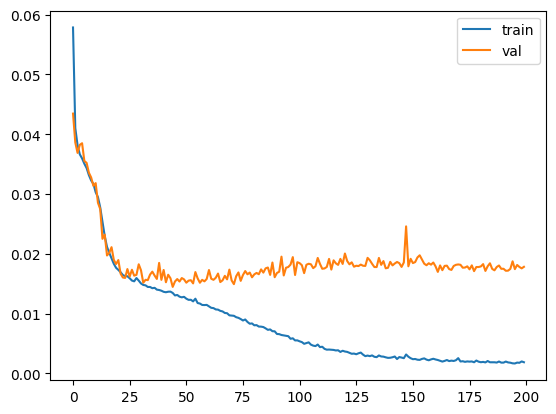

In [26]:
plt.plot(history)
plt.legend(["train", "val"]);

# Evaluation

In [38]:
model.load_state_dict(torch.load(f"./models/{model_name}.pth"))
model.eval()
X_val = val_dataset.data_X
x_val = val_dataset.data_x
y_val = val_dataset.data_y
preds = (
    torch.clamp(
    model(X_val.to(torch.float32).to(DEVICE), x_val.to(torch.float32).to(DEVICE))
    .detach()
    .cpu()
    , min=0, max=1)
    .numpy()
    )
ground_truth = (y_val).numpy()

## MAE

In [39]:
print(np.abs(preds[..., 0] - ground_truth).mean().round(4))

0.0931


## Kernel Density Estimation plot

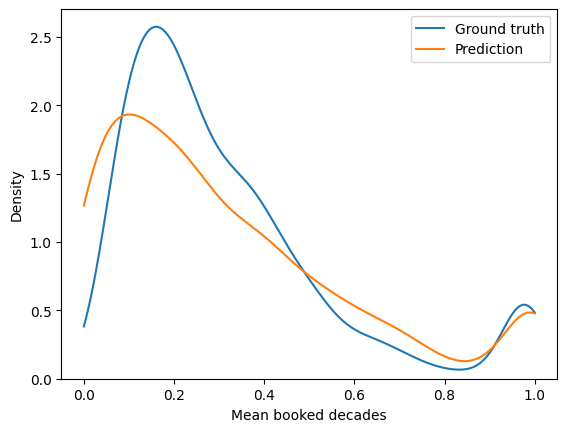

In [72]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.distplot(preds[..., 0],  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Ground truth')
    sns.distplot(ground_truth,  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Prediction')
    plt.legend();
    plt.xlabel("Mean booked decades");

## Scatter plot of ground_truth and preds

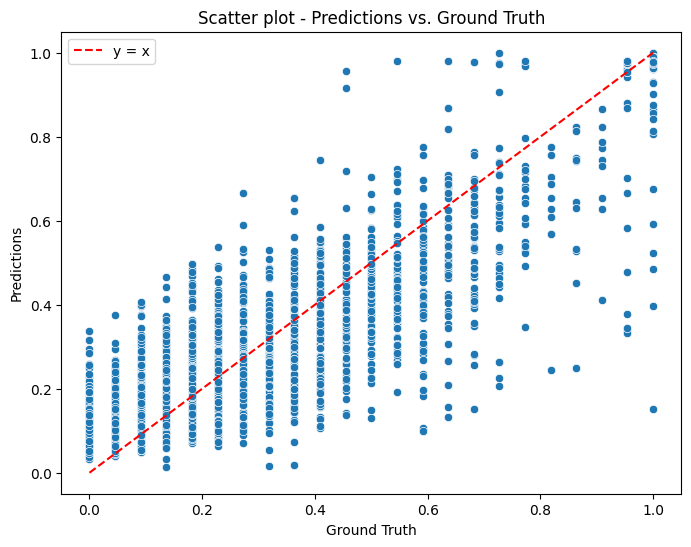

In [51]:
# Create a diagonal line for y = x
x_values = np.linspace(
    min(preds[..., 0].min(), ground_truth.min()),
    max(preds[..., 0].max(), ground_truth.max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth, y=preds[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Ground Truth")

plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()